In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
pd.set_option('display.max_columns', None)
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('.')
sys.path.append('./scripts')
from competing_methods_local import *
from simulations_util import *
from util import  apply_splitting_strategy
from sklearn.preprocessing import StandardScaler

/accounts/projects/binyu/zhongyuan_liang/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'lightgrey'

### Classification

In [3]:
# task = "classification" 
# datasets = ["openml_146819", "openml_361070", "openml_361062","openml_9946","openml_43","openml_9978"]
# combined_df = pd.DataFrame()
# for data in datasets:
#     ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
#     split_seeds = [1,2,3,4,5]
#     rf_seeds = [1,2,3]
#     for split_seed in split_seeds:
#         for rf_seed in rf_seeds:
#             df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}/results.csv"))
#             df["data"] = data
#             combined_df = pd.concat([combined_df, df], ignore_index=True)

In [4]:
task = "classification" 
combined_df = pd.DataFrame()
datasets = ["openml_146819", "openml_361070", "openml_361062","openml_9946","openml_43","openml_9978"]
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection_vary_sample_size_gradient_boosting_new_depth_weight/varying_sample_row_n"
    split_seeds = [1,2,3,4]
    rf_seed = 1
    sample_seeds = [1,2,3,4,5]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)
df = combined_df.groupby(['sample_row_n', 'fi', 'data'])[["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]].mean().reset_index()    

In [5]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    'LIME_RF',
    'TreeSHAP_RF',
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
}

data_name = {
    "openml_43": "Spam",
    "openml_9946": "Breast Cancer",
    "openml_9978": "Ozone",
    "openml_146819": "Climate",
    "openml_361062": "Pol",
    "openml_361070": "Eye Movement"
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'LoTLA',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA+',
}

/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


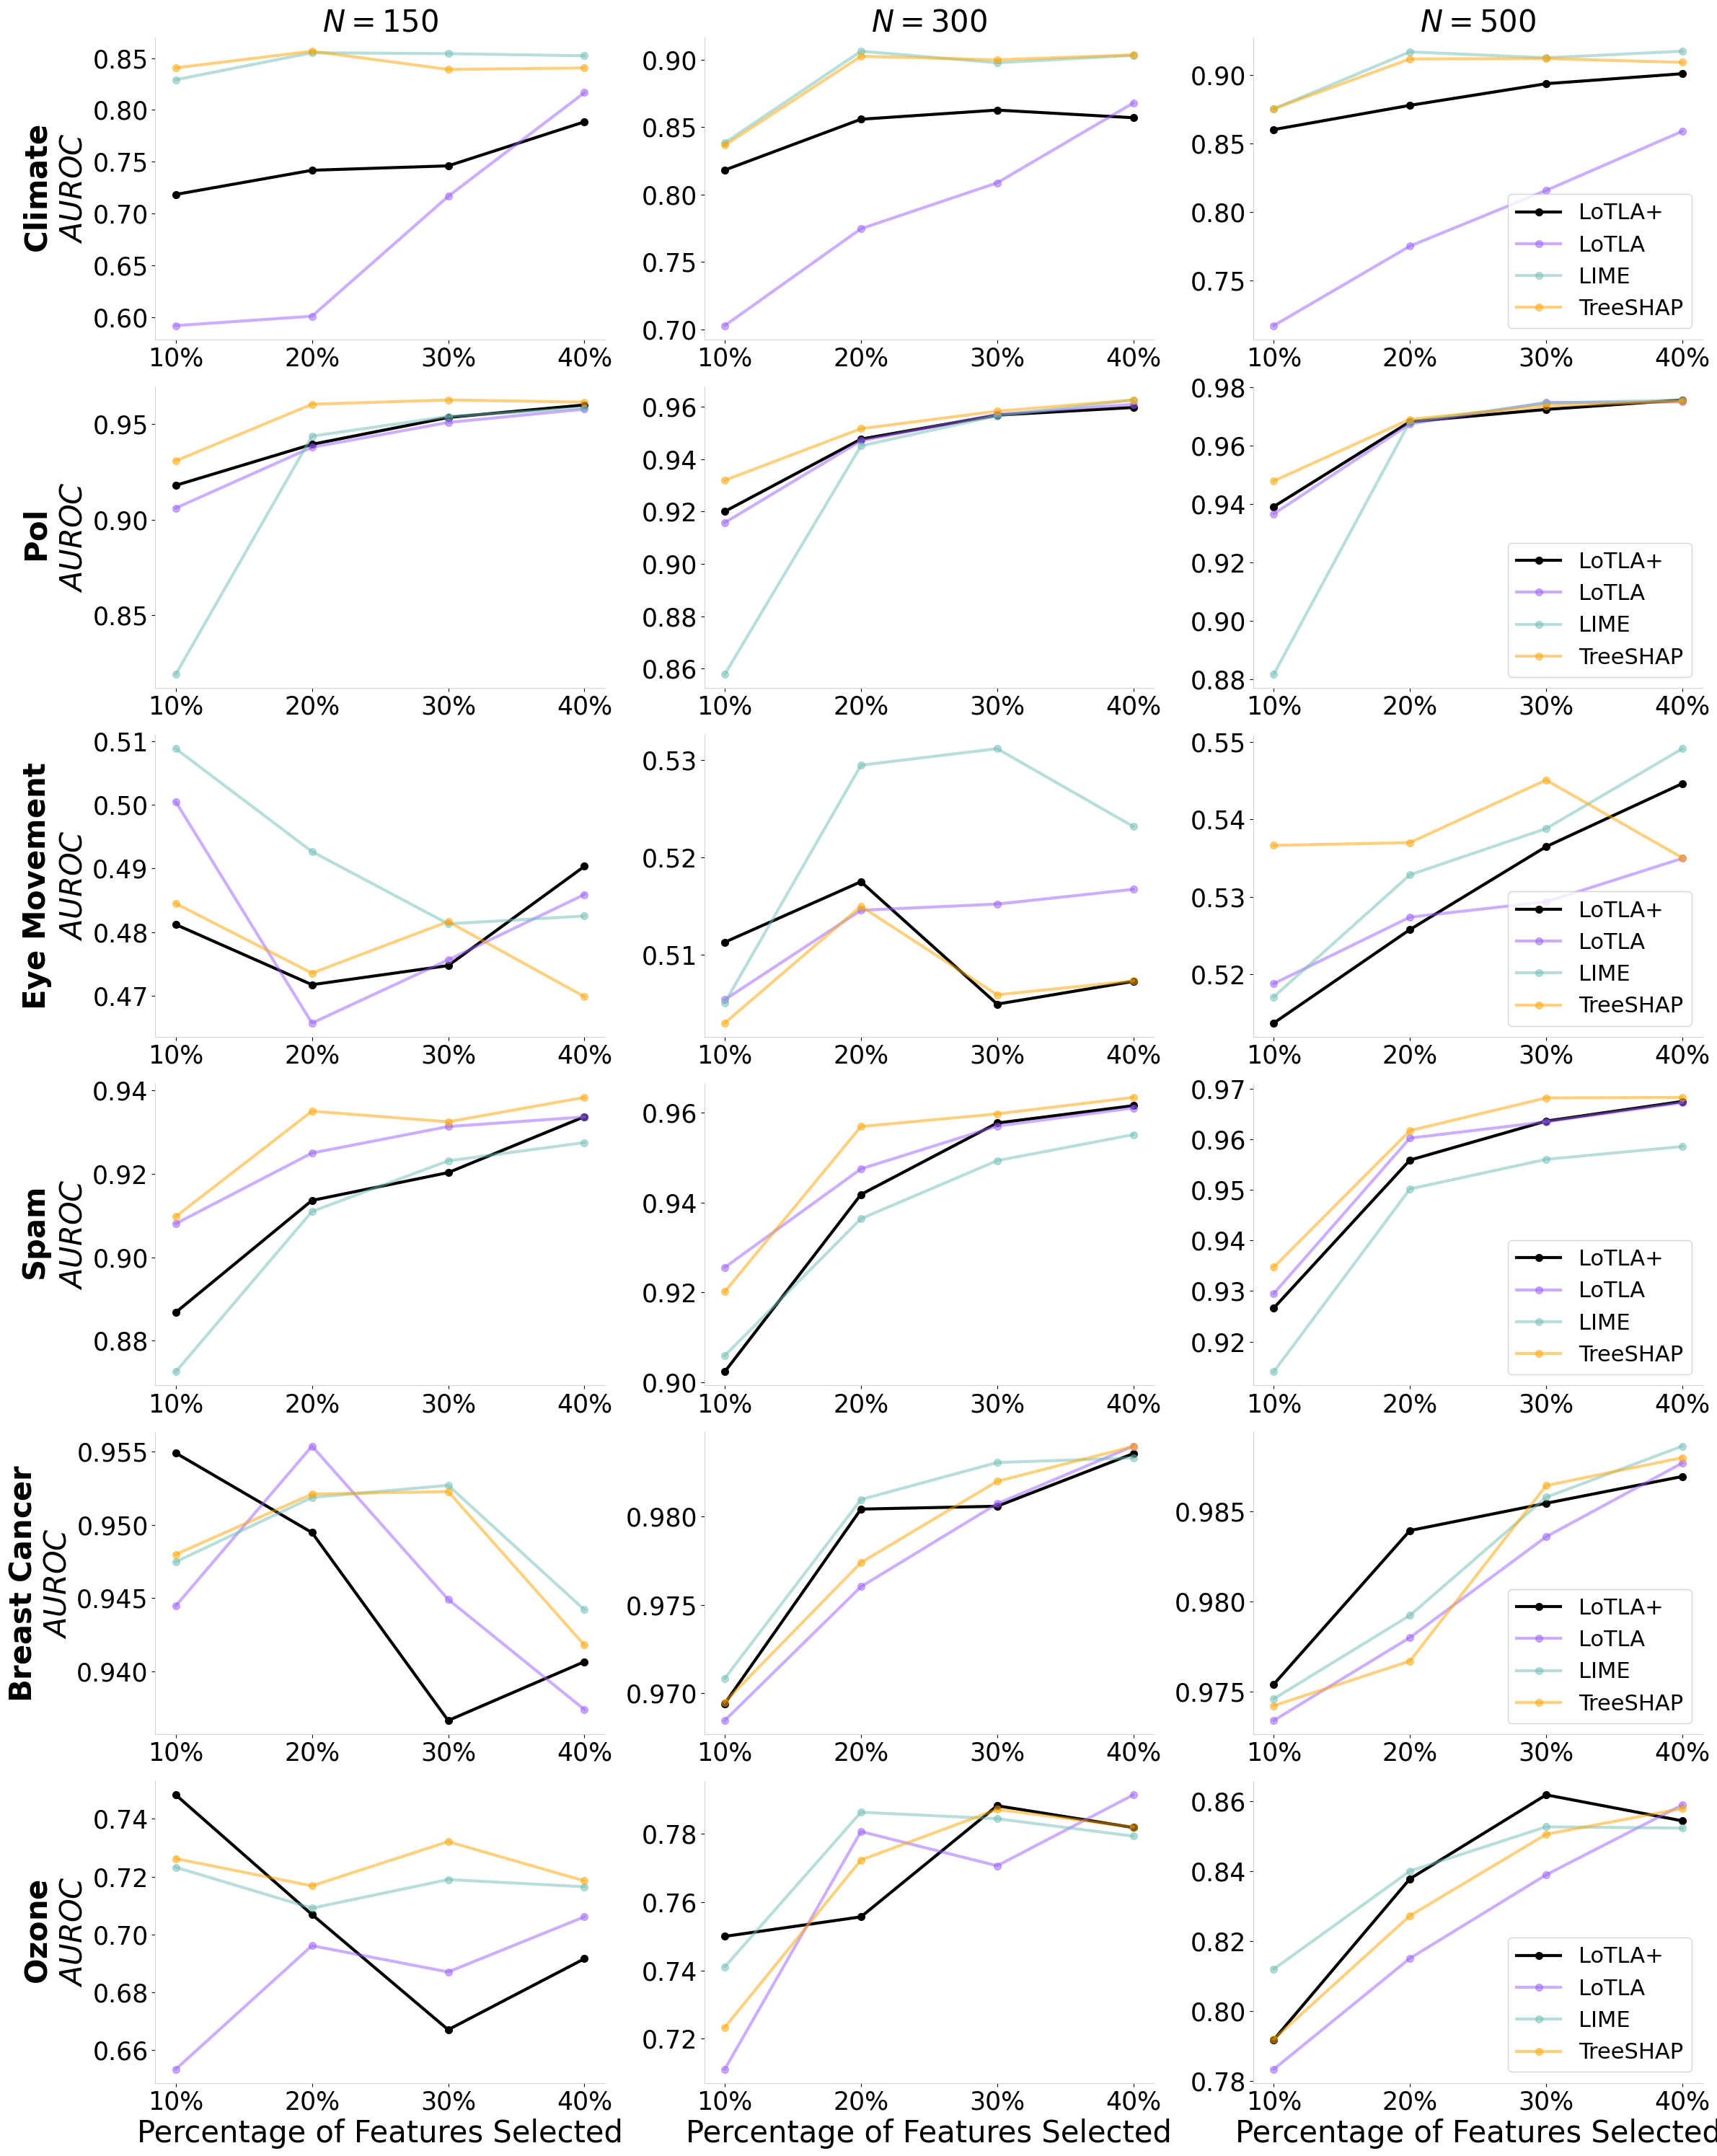

In [6]:
datasets = df["data"].unique()
sample_size_all = df["sample_row_n"].unique()
marker_size = 7

# Number of columns is fixed (4 for PVE), number of rows is based on the number of datasets
n_cols = len(sample_size_all)  # One column per PVE
n_rows = len(datasets)          # One row per dataset

# Create subplots
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 5 * n_rows),
    sharey=False  # Share y-axis across columns for easier comparison
)

# Ensure axs is 2D for easy indexing
if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

# Loop through each dataset (row) and PVE (column)
for row_idx, dataset in enumerate(datasets):
    for col_idx, sample_size in enumerate(sample_size_all):
        ax = axs[row_idx, col_idx]
        subset = df[(df["data"] == dataset) & (df["sample_row_n"] == sample_size)]
        
        # Plot results for each method
        for method in methods:
            method_data = subset[subset["fi"] == method]
            
            if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI']:
                ax.plot(
                    [0.1, 0.2, 0.3, 0.4], method_data[["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]].values[0],
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3, alpha=0.5
                )
            else:
                ax.plot(
                    [0.1, 0.2, 0.3, 0.4], method_data[["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]].values[0], 
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3
                )
        
        # Set x-axis labels and ticks
        ax.set_xticks([0.1, 0.2, 0.3, 0.4])
        ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=25)
        ax.tick_params(axis='y', labelsize=25)
        if row_idx == n_rows - 1:  # Label x-axis only for the last row
            ax.set_xlabel("Percentage of Features Selected", fontsize=30)
        
        # Set y-axis labels only for the first column
        if col_idx == 0:
            dataset_label = data_name[dataset].replace(' ', r'\ ')
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\n$AUROC$", fontsize=30)
        else:
            ax.set_ylabel("")
        
        # set this for the first row
        if row_idx == 0:
            ax.set_title(rf"$N = {sample_size}$", fontsize=30)

        # Add legend to the last subplot of the row
        if col_idx == n_cols - 1:
            ax.legend(fontsize=22, loc='lower right')

# Adjust layout and spacing
plt.tight_layout(rect=[0.01, 0, 1, 1])
plt.savefig("feature_selection_classification_vary_sample_size.png")
plt.show()

In [10]:
# df = combined_df
# datasets = df["data"].unique()

# marker_size = 7
# dotted_methods = ['LIME_RF', 'TreeSHAP_RF', 'MDI']  # This is retained in case you need it later

# # Determine number of rows and columns
# n_cols = 3
# n_rows = 2#len(datasets) // n_cols

# # Create subplots
# fig, axs = plt.subplots(
#     nrows=n_rows,
#     ncols=n_cols,
#     figsize=(8 * n_cols, 6 * n_rows),
#     sharey=False
# )

# # Flatten axes for easier indexing
# axs = axs.flatten()

# # Loop through each dataset
# for idx, dataset in enumerate(datasets):
#     ax = axs[idx]
#     subset = df[df["data"] == dataset]
    
#     # Plot results for each method
#     for method in methods:
#         method_data = subset[subset["fi"] == method]
#         results = method_data[
#             ["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]
#         ].mean(axis=0).values
        
#         if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI']:
#             ax.plot(
#                 [0.1, 0.2, 0.3, 0.4], results,
#                 label=methods_name[method], linestyle='solid',  # Only dotted lines
#                 marker='o', markersize=marker_size, color=color_map[method], linewidth=3, alpha=0.5
#             )
#         else:
#             ax.plot(
#                 [0.1, 0.2, 0.3, 0.4], results,
#                 label=methods_name[method], linestyle='solid',  # Only solid lines
#                 marker='o', markersize=marker_size, color=color_map[method], linewidth=3
#             )
    
#     # Set x-axis and labels
#     ax.set_xticks([0.1, 0.2, 0.3, 0.4])
#     ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=22)
#     if idx >= (n_rows - 1) * n_cols:
#         ax.set_xlabel("Percentage of Features Selected", fontsize=25)
    
#     # Only set y-axis label for the first plot in each row
#     if idx % n_cols == 0:
#         ax.set_ylabel("AUROC", fontsize=24)
#     else:
#         ax.set_ylabel("")
    
#     # Set subplot title
#     dataset_label = data_name[dataset].replace(' ', r'\ ')
#     ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=25)
    
#     # Add legend to the last plot in each row
#     if (idx + 1) % n_cols == 0 or idx == len(datasets) - 1:
#         ax.legend(fontsize=18, loc='lower right')

# plt.tight_layout(rect=[0, 0, 1, 1])
# # Add a title at the top
# plt.savefig("feature_selection_classification.png")
# plt.show()


In [11]:
# df = combined_df
# datasets = df["data"].unique()

# marker_size = 7
# dotted_methods = ['LIME_RF', 'TreeSHAP_RF', 'MDI']

# # Determine number of rows and columns
# n_cols = 3
# n_rows = len(datasets) // n_cols

# # Create subplots
# fig, axs = plt.subplots(
#     nrows=n_rows,
#     ncols=n_cols,
#     figsize=(8 * n_cols, 6 * n_rows),
#     sharey=False
# )

# # Flatten axes for easier indexing
# axs = axs.flatten()

# # Loop through each dataset
# for idx, dataset in enumerate(datasets):
#     ax = axs[idx]
#     subset = df[df["data"] == dataset]
    
#     # Plot results for each method
#     for method in methods:
#         method_data = subset[subset["fi"] == method]
#         results = method_data[
#             ["RF_Classifier_AUROC_top_0.1", "RF_Classifier_AUROC_top_0.2", "RF_Classifier_AUROC_top_0.3", "RF_Classifier_AUROC_top_0.4"]
#         ].mean(axis=0).values
        
#         linestyle = 'dotted' if method in dotted_methods else 'solid'
#         ax.plot(
#             [0.1, 0.2, 0.3, 0.4], results,
#             label=methods_name[method], linestyle=linestyle,
#             marker='o', markersize=marker_size, color=color_map[method]
#         )
    
#     # Set x-axis and labels
#     ax.set_xticks([0.1, 0.2, 0.3, 0.4])
#     ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=15)
#     if idx >= (n_rows - 1) * n_cols:
#         ax.set_xlabel("Percentage of features selected", fontsize=22)
    
#     # Only set y-axis label for the first plot in each row
#     if idx % n_cols == 0:
#         ax.set_ylabel("AUROC", fontsize=24)
#     else:
#         ax.set_ylabel("")
    
#     # Set subplot title
#     ax.set_title(f"{data_name[dataset]}", fontsize=24)
    
#     # Add legend to the last plot in each row
#     if (idx + 1) % n_cols == 0 or idx == len(datasets) - 1:
#         ax.legend(fontsize=18, loc='lower right')

# plt.tight_layout(rect=[0, 0, 1, 0.9])
# # Add a title at the top
# plt.suptitle(
#     "Feature Selection Experiments - Classification Datasets", 
#     fontsize=30,  # Larger font size
#     fontweight='bold',  # Bold text
#     ha='center'  # Center-align the title
# )
# plt.show()

### Regression

In [12]:
task = "regression" 
combined_df = pd.DataFrame()
datasets = ["openml_361260", "openml_361622", "openml_361254",  "openml_361259", "openml_361253", "openml_361242"]
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection_vary_sample_size_gradient_boosting_new_depth_weight/varying_sample_row_n"
    split_seeds = [1,2,3,4]
    rf_seed = 1
    sample_seeds = [1,2,3,4,5]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{rf_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)
df = combined_df.groupby(['sample_row_n', 'fi', 'data'])[["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]].mean().reset_index()            

In [13]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    'LIME_RF',
    'TreeSHAP_RF',
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
}

data_name = {
    "openml_361260": "Miami Housing",
    "openml_361622": "Cars",
    "openml_361254": "SARCOS",
    "openml_361259": "Puma Robot",
    "openml_361253": "Wave Energy",
    "openml_361242": "Super Conductivitity"
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'LoTLA',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA+',
}

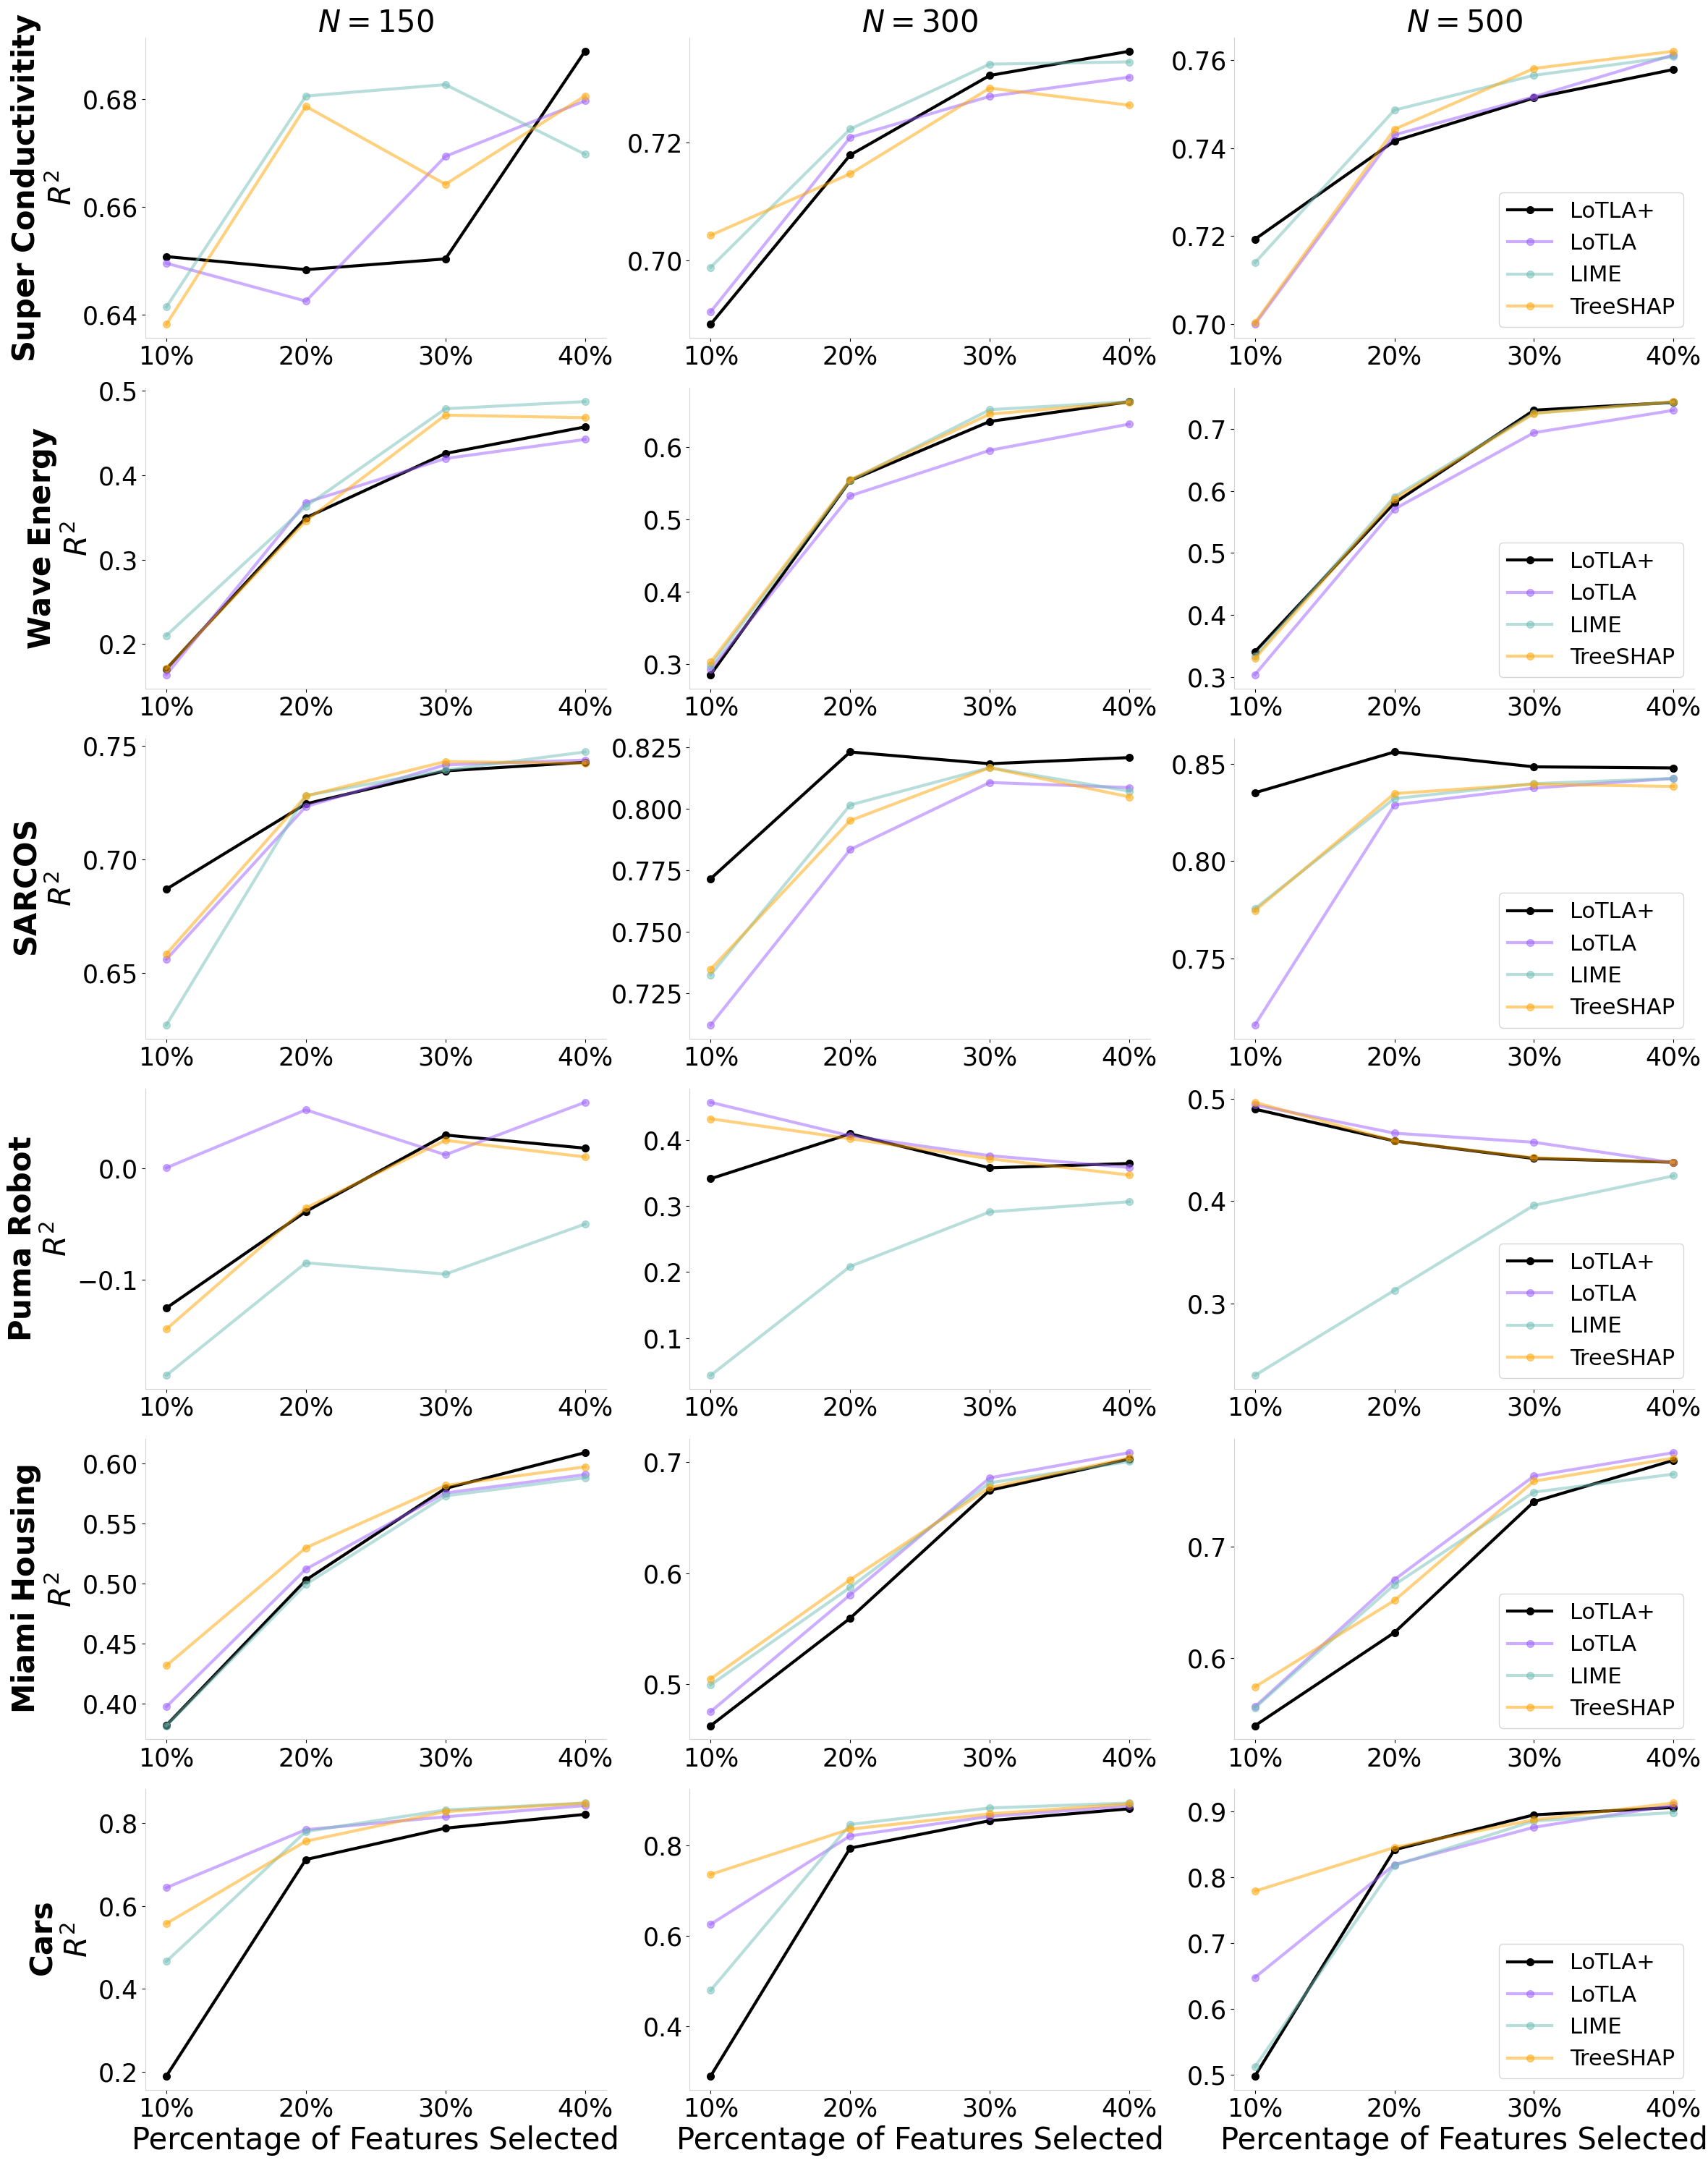

In [14]:
datasets = df["data"].unique()
sample_size_all = df["sample_row_n"].unique()
marker_size = 7

# Number of columns is fixed (4 for PVE), number of rows is based on the number of datasets
n_cols = len(sample_size_all)  # One column per PVE
n_rows = len(datasets)          # One row per dataset

# Create subplots
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 5 * n_rows),
    sharey=False  # Share y-axis across columns for easier comparison
)

# Ensure axs is 2D for easy indexing
if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

# Loop through each dataset (row) and PVE (column)
for row_idx, dataset in enumerate(datasets):
    for col_idx, sample_size in enumerate(sample_size_all):
        ax = axs[row_idx, col_idx]
        subset = df[(df["data"] == dataset) & (df["sample_row_n"] == sample_size)]
        
        # Plot results for each method
        for method in methods:
            method_data = subset[subset["fi"] == method]
            
            if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI']:
                ax.plot(
                    [0.1, 0.2, 0.3, 0.4], method_data[["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]].values[0],
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3, alpha=0.5
                )
            else:
                ax.plot(
                    [0.1, 0.2, 0.3, 0.4], method_data[["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]].values[0], 
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3
                )
        
        # Set x-axis labels and ticks
        ax.set_xticks([0.1, 0.2, 0.3, 0.4])
        ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=25)
        ax.tick_params(axis='y', labelsize=25)
        if row_idx == n_rows - 1:  # Label x-axis only for the last row
            ax.set_xlabel("Percentage of Features Selected", fontsize=30)
        
        # Set y-axis labels only for the first column
        if col_idx == 0:
            dataset_label = data_name[dataset].replace(' ', r'\ ')
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\n$R^2$", fontsize=30)
        else:
            ax.set_ylabel("")
        
        # set this for the first row
        if row_idx == 0:
            ax.set_title(rf"$N = {sample_size}$", fontsize=30)

        # Add legend to the last subplot of the row
        if col_idx == n_cols - 1:
            ax.legend(fontsize=22, loc='lower right')

# Adjust layout and spacing
plt.tight_layout(rect=[0.01, 0, 1, 1])
plt.savefig("feature_selection_regression_vary_sample_size.png")
plt.show()

In [15]:
# df = combined_df
# datasets = df["data"].unique()

# marker_size = 7

# # Determine number of rows and columns
# n_cols = 3
# n_rows = 2  # len(datasets) // n_cols

# # Create subplots
# fig, axs = plt.subplots(
#     nrows=n_rows,
#     ncols=n_cols,
#     figsize=(8 * n_cols, 6 * n_rows),
#     sharey=False
# )

# # Flatten axes for easier indexing
# axs = axs.flatten()

# # Loop through each dataset
# for idx, dataset in enumerate(datasets):
#     ax = axs[idx]
#     subset = df[df["data"] == dataset]
    
#     # Plot results for each method
#     for method in methods:
#         method_data = subset[subset["fi"] == method]
#         results = method_data[
#             ["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]
#         ].mean(axis=0).values
        
#         if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI']:
#             ax.plot(
#                 [0.1, 0.2, 0.3, 0.4], results,
#                 label=methods_name[method], linestyle='solid',  # Only solid lines
#                 marker='o', markersize=marker_size, color=color_map[method], linewidth=3, alpha=0.5
#             )
#         else:
#             ax.plot(
#                 [0.1, 0.2, 0.3, 0.4], results,
#                 label=methods_name[method], linestyle='solid',  # Only solid lines
#                 marker='o', markersize=marker_size, color=color_map[method], linewidth=3
#             )
    
#     # Set x-axis and labels
#     ax.set_xticks([0.1, 0.2, 0.3, 0.4])
#     ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=22)
#     if idx >= (n_rows - 1) * n_cols:
#         ax.set_xlabel("Percentage of Features Selected", fontsize=25)
    
#     # Only set y-axis label for the first plot in each row
#     if idx % n_cols == 0:
#         ax.set_ylabel(r"$R^2$", fontsize=24)
#     else:
#         ax.set_ylabel("")
    
#     # Set subplot title
#     dataset_label = data_name[dataset].replace(' ', r'\ ')
#     ax.set_title(f"$\\mathbf{{{dataset_label}}}$", fontsize=25)
    
#     # Add legend to the last plot in each row
#     if (idx + 1) % n_cols == 0 or idx == len(datasets) - 1:
#         ax.legend(fontsize=18, loc='lower right')

# # Adjust layout and show plot
# plt.tight_layout(rect=[0, 0, 1, 1])
# # Add a title at the top
# plt.savefig("feature_selection_regression.png")
# plt.show()

In [16]:
# df = combined_df
# datasets = df["data"].unique()

# marker_size = 7

# # Determine number of rows and columns
# n_cols = 3
# n_rows = len(datasets) // n_cols

# # Create subplots
# fig, axs = plt.subplots(
#     nrows=n_rows,
#     ncols=n_cols,
#     figsize=(8 * n_cols, 6.5 * n_rows),
#     sharey=False
# )

# # Flatten axes for easier indexing
# axs = axs.flatten()

# # Loop through each dataset
# for idx, dataset in enumerate(datasets):
#     ax = axs[idx]
#     subset = df[df["data"] == dataset]
    
#     # Plot results for each method
#     for method in methods:
#         method_data = subset[subset["fi"] == method]
#         results = method_data[
#             ["RF_Regressor_R2_top_0.1", "RF_Regressor_R2_top_0.2", "RF_Regressor_R2_top_0.3", "RF_Regressor_R2_top_0.4"]
#         ].mean(axis=0).values
        
#         linestyle = 'dotted' if method in dotted_methods else 'solid'
#         ax.plot(
#             [0.1, 0.2, 0.3, 0.4], results,
#             label=methods_name[method], linestyle=linestyle,
#             marker='o', markersize=marker_size, color=color_map[method]
#         )
    
#     # Set x-axis and labels
#     ax.set_xticks([0.1, 0.2, 0.3, 0.4])
#     ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=15)
#     if idx >= (n_rows - 1) * n_cols:
#         ax.set_xlabel("Percentage of features selected", fontsize=22)
    
#     # Only set y-axis label for the first plot in each row
#     if idx % n_cols == 0:
#         ax.set_ylabel("R-Square", fontsize=24)
#     else:
#         ax.set_ylabel("")
    
#     # Set subplot title
#     ax.set_title(f"{data_name[dataset]}", fontsize=24)
    
#     # Add legend to the last plot in each row
#     if (idx + 1) % n_cols == 0 or idx == len(datasets) - 1:
#         ax.legend(fontsize=18, loc='lower right')

# # Adjust layout and show plot
# plt.tight_layout(rect=[0, 0, 1, 0.9])
# # Add a title at the top
# plt.suptitle(
#     "Feature Selection Experiments - Regression Datasets", 
#     fontsize=30,  # Larger font size
#     fontweight='bold',  # Bold text
#     ha='center'  # Center-align the title
# )
# plt.show()